# Experiment 7 Time Series Prediction - Advanced use of recurrent neural networks

# Task

Implement the time series prediction with jena climate dataset using Recurrent Network Layers, try to pass different arguments to observe
the result, plot the results and analyze the differences. There are many other things to try, in order to improve performance on the
temperature-forecasting problem:
<ul>
    <li> Adjust the number of units in each recurrent layer in the stacked setup
    <li> Adjust the learning rate used by the RMSprop optimizer.
    <li> Try using LSTM layers instead of GRU layers.
    <li> Try using a bigger densely connected regressor on top of the recurrent layers: Don't forget to eventually run the best-performing models on the test set! Otherwise, you'll develop architectures that are overfitting to the validation set.
</ul>

# 1 Download and plot jena climate data

## 1.1 Download and plot jena climate data

https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip (https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip)

In [2]:
import os
data_dir = './jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')
f = open(fname)
data = f.read()
f.close()
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [24]:
lines[1:12]

['01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.10',
 '01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.60',
 '01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.00',
 '01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.30',
 '01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.40,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.70',
 '01.01.2009 01:10:00,996.50,-7.62,265.81,-8.30,94.80,3.44,3.26,0.18,2.04,3.27,1305.68,0.18,0.63,166.50',
 '01.01.2009 01:20:00,996.50,-7.62,265.81,-8.36,94.40,3.44,3.25,0.19,2.03,3.26,1305.69,0.19,0.50,118.60',
 '01.01.2009 01:30:00,996.50,-7.91,265.52,-8.73,93.80,3.36,3.15,0.21,1.97,3.16,1307.17,0.28,0.75,188.50',
 '01.01.2009 01:40:00,996.53,-8.43,264.99,-9.34,93.10,3.23,3.00,0.22,1.88,3.02,1309.85,0.59,0.88,185.00',
 '01.01.2009 01:50:00,996.62,-8.76,264.66,-9.6

In [25]:
1440/2

720.0

## 1.2 Parsing the data and convert all of data into a Numpy array

In [3]:
import numpy as np
float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

## 1.3 Plot of temperature

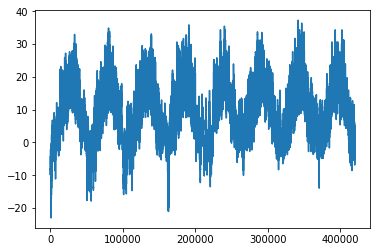

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
temp = float_data[:, 1] # temperature (in degrees Celsius)
plt.plot( temp )

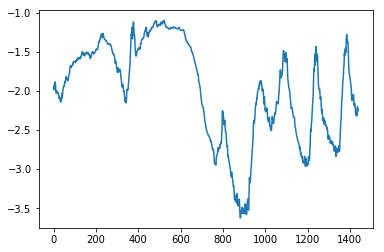

In [23]:
# plot tempreture of first 10 days
plt.plot( temp[:6*24*10] )

# 2 Preparing the data

## 2.1 Normalizing the data

In [6]:
 mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

## 2.2 Data generator

In [7]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [8]:
lookback = 1440
step = 6
delay = 144
batch_size = 128
train_gen = generator(float_data, lookback=lookback, delay=delay, min_index=0,
                      max_index=200000, shuffle=True, step=step, batch_size=batch_size)
val_gen = generator(float_data, lookback=lookback, delay=delay, min_index=200001,
                    max_index=300000, step=step, batch_size=batch_size)
test_gen = generator(float_data, lookback=lookback, delay=delay, min_index=300001,
                     max_index=None, step=step, batch_size=batch_size)
val_steps = (300000 - 200001 - lookback)
test_steps = (len(float_data) - 300001 - lookback)

In [9]:
val_steps

98559

In [10]:
test_steps

119110

# 3 A non-machine-learning baseline

In [11]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    return np.mean(batch_maes)

In [12]:
evaluate_naive_method()

0.28969941979609765


In [13]:
celsius_mae = 0.29 * std[1]
celsius_mae

2.5672247338393395

# 4 A basic machine-learning approach

In [14]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(train_gen, steps_per_epoch=5, epochs=20, validation_data=val_gen,
                              validation_steps=val_steps/batch_size/10)

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
5/5 [==============================] - 2s 322ms/step - loss: 4.0311 - val_loss: 5.5021
Epoch 2/20
5/5 [==============================] - 1s 156ms/step - loss: 3.0861 - val_loss: 3.0737
Epoch 3/20
5/5 [==============================] - 1s 153ms/step - loss: 2.6318 - val_loss: 3.9476
Epoch 4/20
5/5 [==============================] - 1s 172ms/step - loss: 2.2752 - val_loss: 1.1283
Epoch 5/20
5/5 [==============================] - 1s 159ms/step - loss: 2.1693 - val_loss: 2.8053
Epoch 6/20
5/5 [==============================] - 1s 166ms/step - loss: 2.2371 - val_loss: 1.6168
Epoch 7/20
5/5 [==============================] - 1s 169ms/step - loss: 1.9666 - val_loss: 1.2507
Epoch 8/20
5/5 [==============================] - 1s 175ms/step - loss: 1.7691 - val_loss: 2.3676
Epoch 9/20
5/5 [==============================] - 1s 175ms/step - loss: 2.3826 - val_loss: 1.365

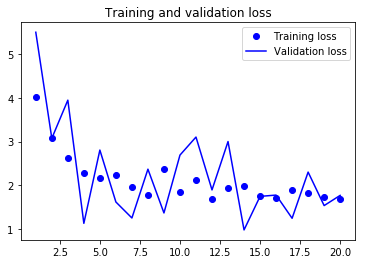

In [16]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# 5 Training and evaluating a GRU-based model

In [27]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=50, epochs=20, 
                              validation_data=val_gen, validation_steps=val_steps/batch_size/10)

Epoch 1/20
50/50 [==============================] - 10s 198ms/step - loss: 0.3539 - val_loss: 0.2778
Epoch 2/20
50/50 [==============================] - 7s 135ms/step - loss: 0.3063 - val_loss: 0.2841
Epoch 3/20
50/50 [==============================] - 7s 136ms/step - loss: 0.2980 - val_loss: 0.2656
Epoch 4/20
50/50 [==============================] - 7s 150ms/step - loss: 0.2939 - val_loss: 0.3044
Epoch 5/20
50/50 [==============================] - 7s 142ms/step - loss: 0.2912 - val_loss: 0.2875
Epoch 6/20
50/50 [==============================] - 7s 146ms/step - loss: 0.2983 - val_loss: 0.2693
Epoch 7/20
50/50 [==============================] - 8s 151ms/step - loss: 0.2886 - val_loss: 0.3229
Epoch 8/20
50/50 [==============================] - 8s 151ms/step - loss: 0.2895 - val_loss: 0.2551
Epoch 9/20
50/50 [==============================] - 7s 140ms/step - loss: 0.2939 - val_loss: 0.2596
Epoch 10/20
50/50 [==============================] - 7s 149ms/step - loss: 0.2853 - val_loss: 0.235

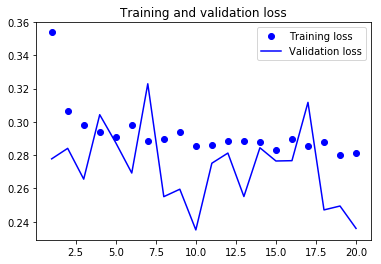

In [28]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# 6 Training and evaluating a dropout-regularized GRU-based model

In [29]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.GRU(32, dropout=0.2, recurrent_dropout=0.2, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=50, epochs=20,
                              validation_data=val_gen, validation_steps=val_steps/batch_size/10)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Epoch 1/20
50/50 [==============================] - 9s 179ms/step - loss: 0.3834 - val_loss: 0.3064
Epoch 2/20
50/50 [==============================] - 8s 168ms/step - loss: 0.3396 - val_loss: 0.2943
Epoch 3/20
50/50 [==============================] - 8s 160ms/step - loss: 0.3395 - val_loss: 0.2936
Epoch 4/20
50/50 [==============================] - 8s 162ms/step - loss: 0.3307 - val_loss: 0.3028
Epoch 5/20
50/50 [==============================] - 9s 176ms/step - loss: 0.3257 - val_loss: 0.2868
Epoch 6/20
50/50 [==============================] - 8s 162ms/step - loss: 0.3266 - val_loss: 0.3004
Epoch 7/20
50/50 [==============================] - 8s 167ms/step - loss: 0.3214 - val_loss: 0.2944
Epoch 8/20
50/50 [==============================] - 8s 168ms/step - loss: 0.3185 - val_loss: 0.2765
Epoch 9/20
50/50 [==============================] - 9s 173ms/step - loss: 0.3175 - va

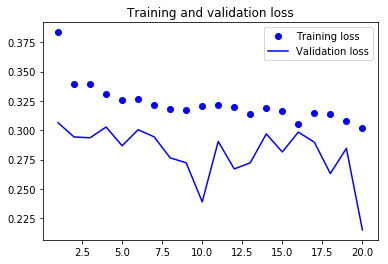

In [30]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# 7 Training and evaluating a dropout-regularized, stacked GRU model

In [31]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, dropout=0.2, recurrent_dropout=0.5, return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu', dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(train_gen, steps_per_epoch=50, epochs=20,
                              validation_data=val_gen, validation_steps=val_steps/batch_size/10)

Epoch 1/20
50/50 [==============================] - 27s 548ms/step - loss: 0.4118 - val_loss: 0.3201
Epoch 2/20
50/50 [==============================] - 26s 522ms/step - loss: 0.3559 - val_loss: 0.3068
Epoch 3/20
50/50 [==============================] - 25s 500ms/step - loss: 0.3471 - val_loss: 0.2663
Epoch 4/20
50/50 [==============================] - 26s 528ms/step - loss: 0.3499 - val_loss: 0.3299
Epoch 5/20
50/50 [==============================] - 26s 519ms/step - loss: 0.3368 - val_loss: 0.2802
Epoch 6/20
50/50 [==============================] - 24s 472ms/step - loss: 0.3427 - val_loss: 0.3109
Epoch 7/20
50/50 [==============================] - 24s 475ms/step - loss: 0.3372 - val_loss: 0.3080
Epoch 8/20
50/50 [==============================] - 24s 474ms/step - loss: 0.3375 - val_loss: 0.2519
Epoch 9/20
50/50 [==============================] - 24s 472ms/step - loss: 0.3334 - val_loss: 0.2748
Epoch 10/20
50/50 [==============================] - 24s 472ms/step - loss: 0.3260 - val_lo

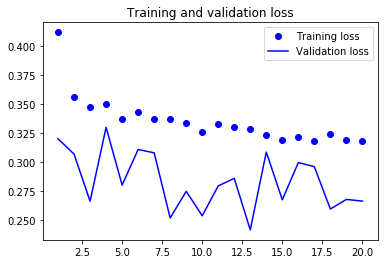

In [32]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# 8 Analysis and Conclusion